In [1]:
!pip install -U opencv-python tensorflow scikit-learn pandas matplotlib tensorflow_datasets


[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python -m pip install --upgrade pip


# IMPORTATION DES LIBRAIRIES

In [2]:
import numpy as np
import pandas as pd
import os
import sklearn
import tensorflow as tf
from tensorflow import keras
import cv2
import matplotlib.pyplot as plt
import tensorflow_datasets.public_api as tfds
import requests
import zipfile
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

2025-08-14 10:40:31.090387: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/usr/local/lib/python3.11/dist-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
/usr

# Chargement du dataset

In [3]:
def telecharger_dezip(url, chemin_sauv="plant_village_dataset.zip", extract_path="."):
    print(" Début du téléchargement")
    try:
        response=requests.get(url, stream=True)
        response.raise_for_status()

        #Taille totale du fichier pour la barre de progression
        total_size=int(response.headers.get('content-length',0))
        block_size=1064
        bar_progression = tqdm(total=total_size, unit='iB', unit_scale=True)

        #Téléchargement
        with open(chemin_sauv, 'wb') as file:
            for data in response.iter_content(block_size):
                bar_progression.update(len(data))
                file.write(data)
        bar_progression.close()

        if total_size != 0 and bar_progression.n != total_size:
            print("ERREUR, quelque chose s'est mal passé pendant le téléchargement.")
            return

        print(f"Téléchargement terminé. Fichier sauvegardé sous : {chemin_sauv}")

        # Créer le dossier d'extraction s'il n'existe pas
        if not os.path.exists(extract_path):
            os.makedirs(extract_path)

        # Décompresser le fichier ZIP
        print(f"Décompression du fichier dans le dossier : {extract_path}")
        with zipfile.ZipFile(chemin_sauv, 'r') as zip_ref:
            zip_ref.extractall(extract_path)

        print("Décompression terminée.")

        # Optionnel : Supprimer le fichier .zip après extraction pour économiser de l'espace
        print(f"Suppression du fichier {chemin_sauv}...")
        os.remove(chemin_sauv)
        print("Opération terminée avec succès !")

    except requests.exceptions.RequestException as e:
        print(f"Une erreur de réseau est survenue: {e}")
    except zipfile.BadZipFile:
        print("Erreur: Le fichier téléchargé n'est pas un fichier ZIP valide.")
    except Exception as e:
        print(f"Une erreur inattendue est survenue: {e}")

In [4]:
URL = "https://data.mendeley.com/datasets/tywbtsjrjv/1/files/b4e3a32f-c0bd-4060-81e9-6144231f2520/file_downloaded"

In [5]:
extract_folder = "plant_village_dataset"

In [6]:
telecharger_dezip(URL, "PlantVillage.zip", extract_folder)

 Début du téléchargement


100%|██████████| 949M/949M [00:45<00:00, 21.0MiB/s]  


Téléchargement terminé. Fichier sauvegardé sous : PlantVillage.zip
Décompression du fichier dans le dossier : plant_village_dataset
Décompression terminée.
Suppression du fichier PlantVillage.zip...
Opération terminée avec succès !


In [7]:
path="/workspace/plant_village_dataset/Plant_leave_diseases_dataset_with_augmentation"

In [8]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

In [9]:
data_gen=ImageDataGenerator(rescale=1./255)

In [10]:
data=data_gen.flow_from_directory(
    path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

Found 61486 images belonging to 39 classes.


# AFFICHAGE DE QUELQUES IMAGES

In [11]:
os.makedirs("/images", exist_ok=True)

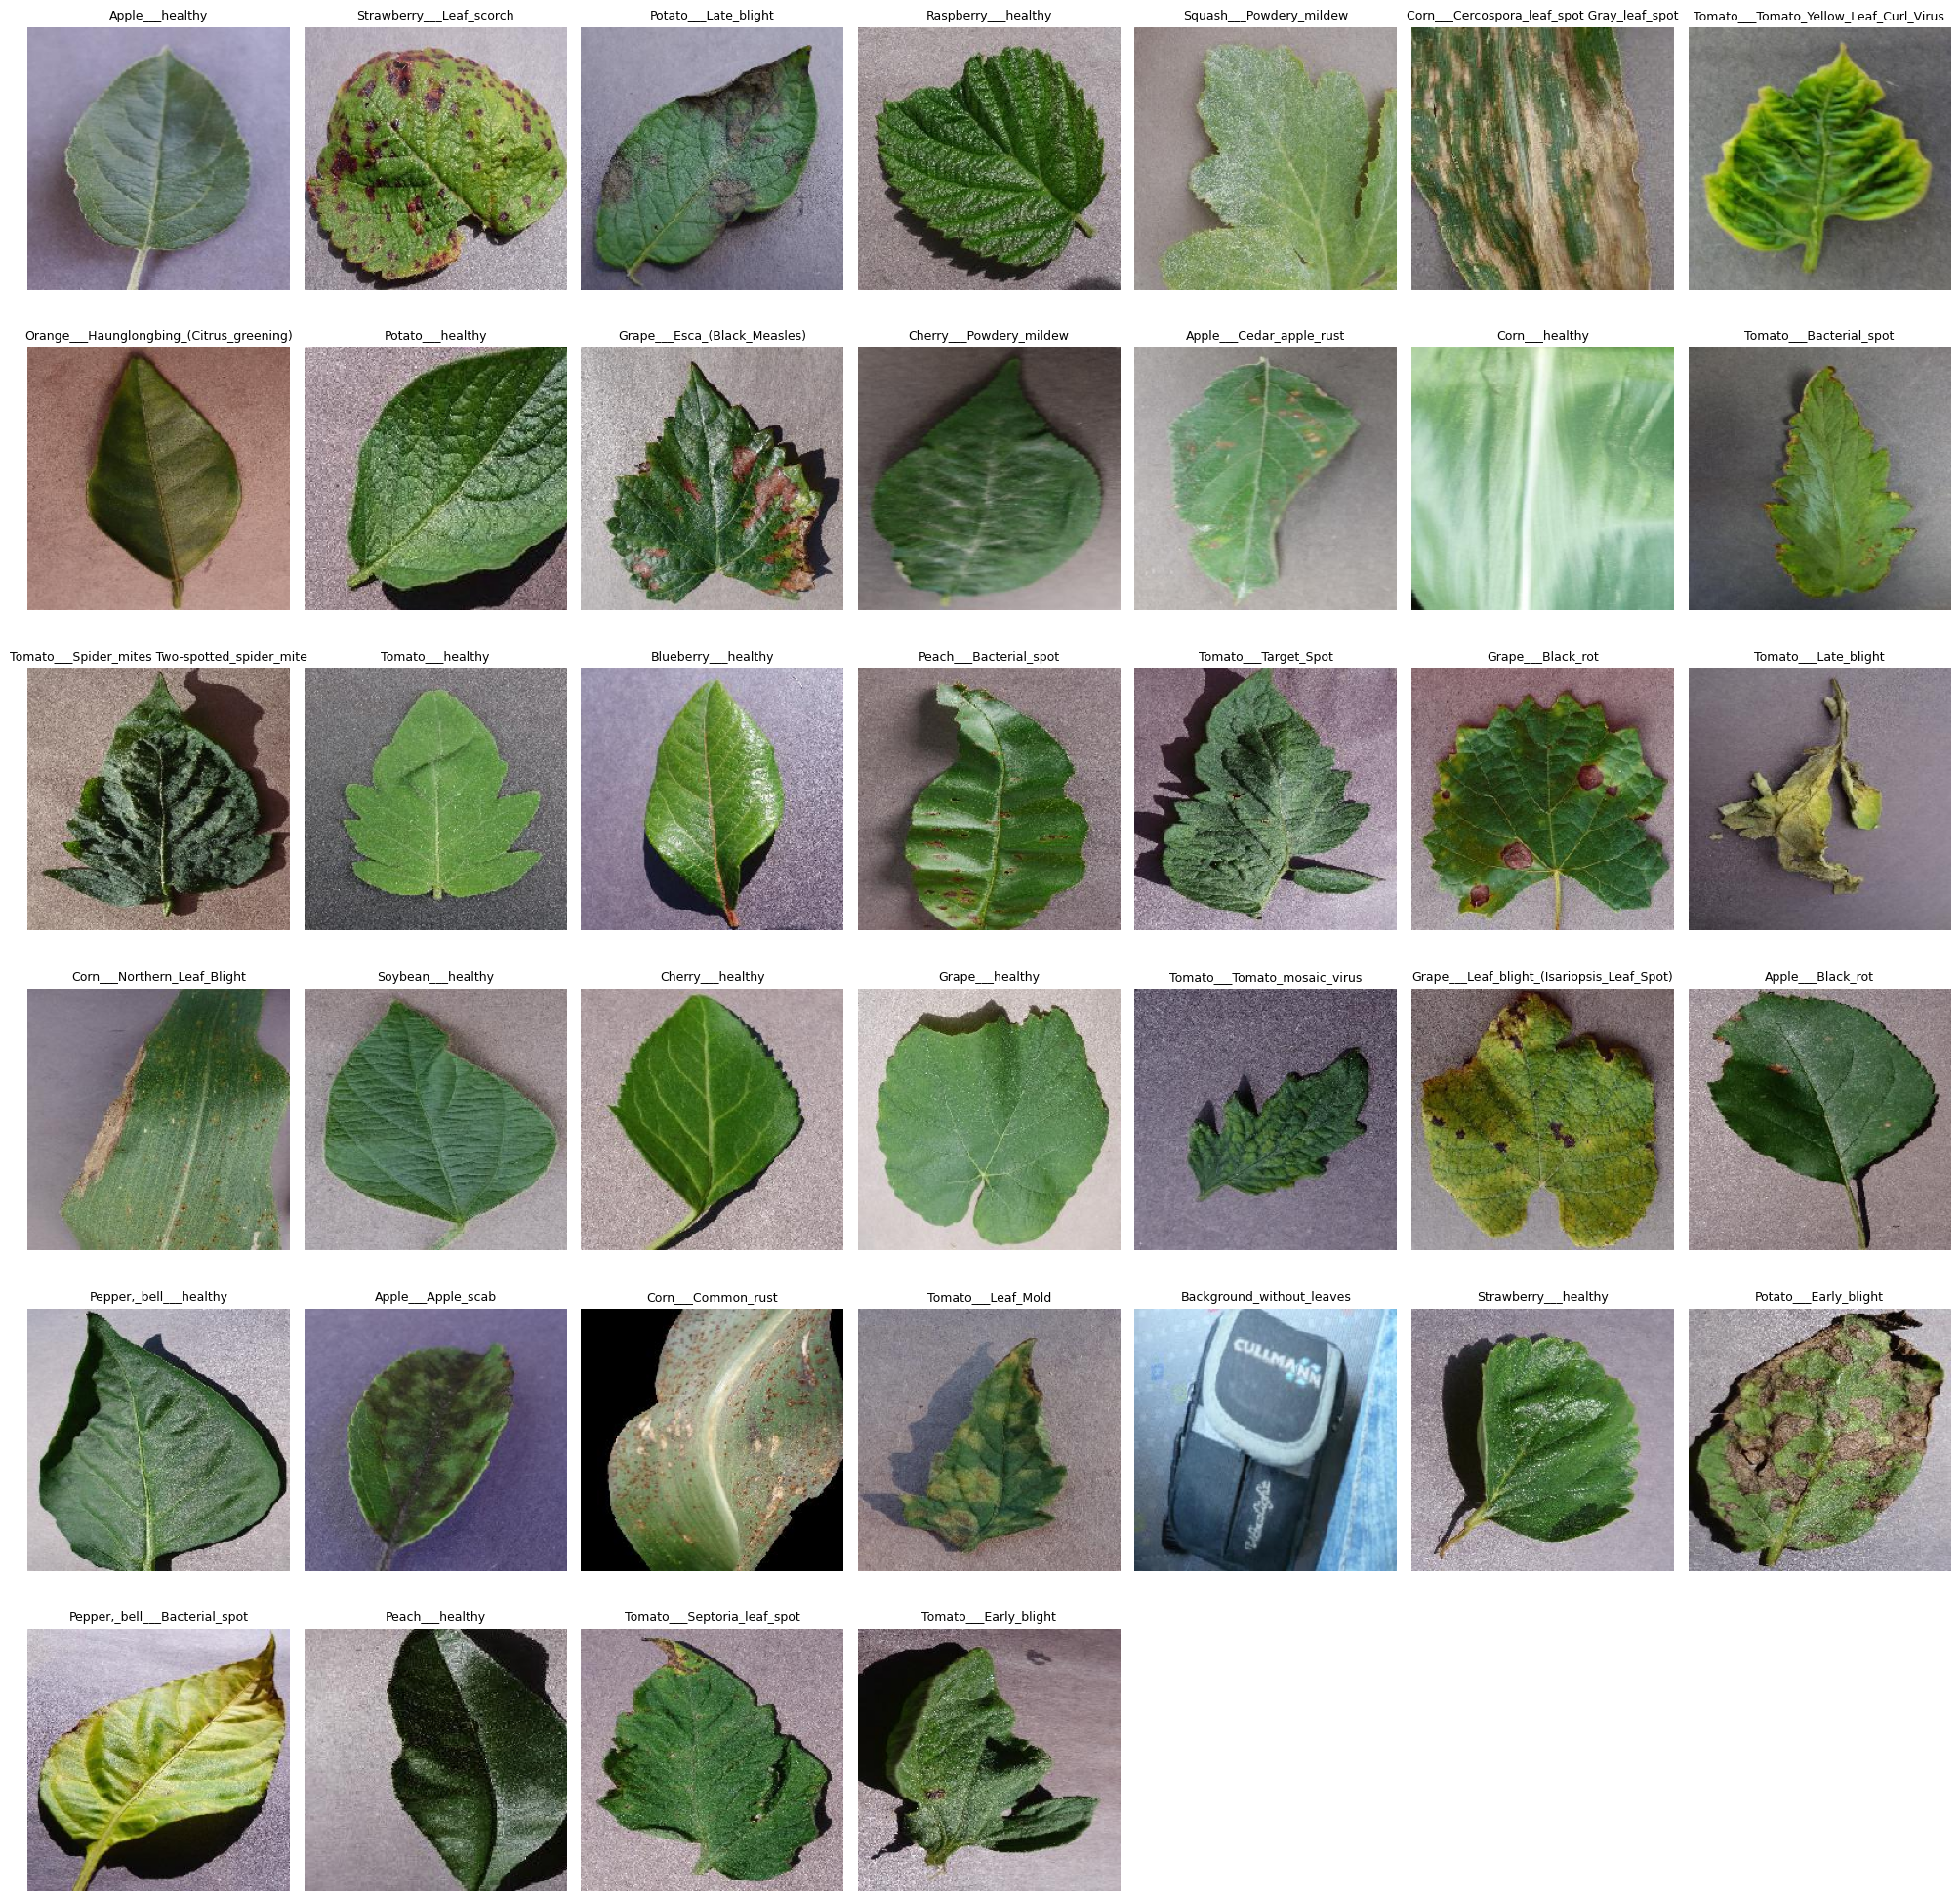

In [12]:
# Mapping des index aux noms de classes
index_to_class = {v: k for k, v in data.class_indices.items()}

# Pour ranger une image par classe
displayed_classes = {}

# Collecter jusqu'à ce qu'on est toutes les classes
for images, labels in data:
    for img, label in zip(images, labels):
        class_index = np.argmax(label)
        if class_index not in displayed_classes:
            displayed_classes[class_index] = (img, class_index)
        if len(displayed_classes) == len(index_to_class):
            break
    if len(displayed_classes) == len(index_to_class):
        break

# Afficher les images 
plt.figure(figsize=(20, 20))
for i, (class_index, (img, _)) in enumerate(displayed_classes.items()):
    plt.subplot(6, 7, i + 1)
    
    # De-normalize if values are in [0.0, 1.0]
    if img.max() <= 1.0:
        img = (img * 255).astype("uint8")
    else:
        img = img.astype("uint8")

    plt.imshow(img)
    plt.title(index_to_class[class_index], fontsize=9)
    plt.axis("off")

plt.tight_layout()
plt.savefig("/images/1.image_par_classe.png")
plt.show()

# EFFECTIFS PAR CLASSE

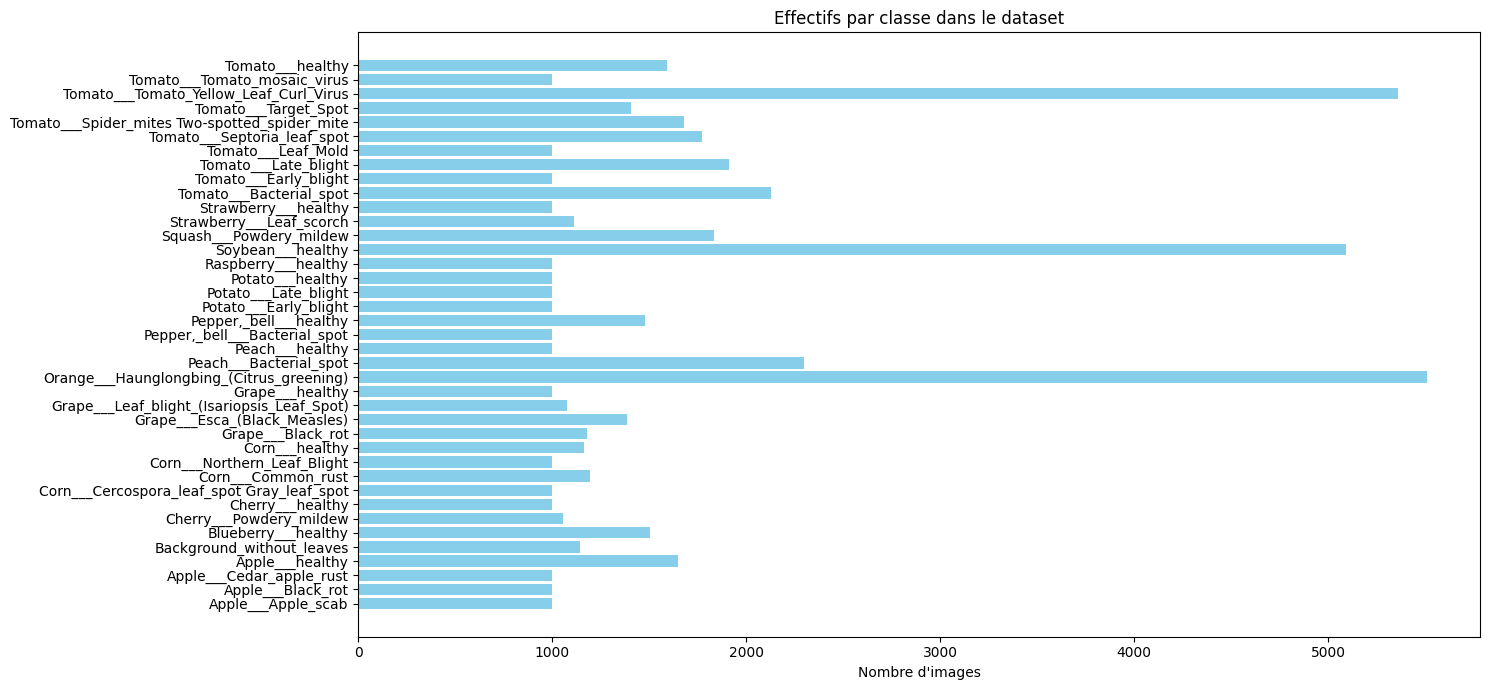

In [13]:
# Compter les occurrences de chaque classe
class_counts = np.bincount(data.classes)

# Noms des classes dans l’ordre
class_names = [index_to_class[i] for i in range(len(class_counts))]

# Affichage de l'histogramme
plt.figure(figsize=(15, 7))
plt.barh(class_names, class_counts, color="skyblue")
plt.xlabel("Nombre d'images")
plt.title("Effectifs par classe dans le dataset")
plt.tight_layout()
plt.savefig("/images/2.effectif_par_classe.png")
plt.show()

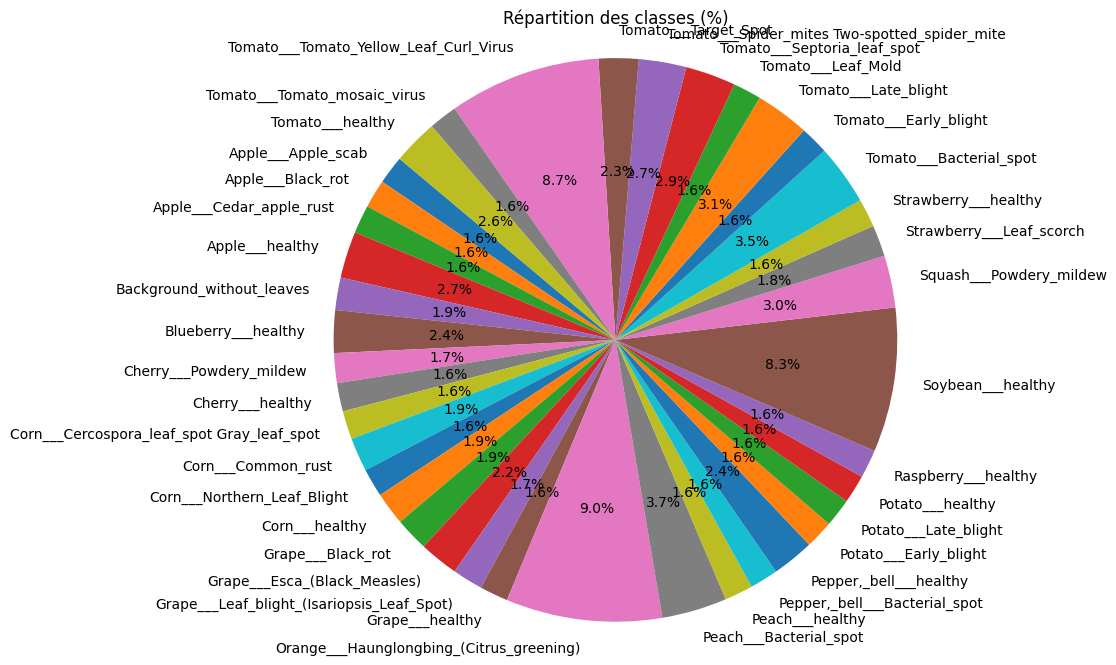

In [14]:
plt.figure(figsize=(8, 8))
plt.pie(class_counts, labels=class_names, autopct="%1.1f%%", startangle=140)
plt.title("Répartition des classes (%)")
plt.axis("equal")
plt.savefig("/images/3.diagram_circ_effectif_par_classe.png")
plt.show()

Les effectifs sont plutôt bien répartis, autour de 1000. Mais on remarque une sur-représentation de certaines classes:
- Tomates de manière générales
- Tomato Yellow Curl Leaf Virus
- Soybean Healthy (Soja en bonne santé)
- Orange Haunglongbing (Citrus greening)

Il faudra garder celà en mémoire et penser à un rééquilibrage des classes dans le cas où on remarquerait un biais envers ces classes


# MODELISATION

## EfficientB0

P, F. R. P., U, A. S., Moustafa, M. A., & Ali, M. A. S. (2023). Detecting plant disease in corn leaf using EfficientNet Architecture—An analytical approach. Electronics, 12(8), 1938. https://doi.org/10.3390/electronics12081938

In [15]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

In [16]:
# --------- 1. Préparer les données ---------
filepaths = []
labels = []
folds = os.listdir(path)
for fold in folds:
    f_path = os.path.join(path, fold)
    if not os.path.isdir(f_path):
        continue
    for file in os.listdir(f_path):
        filepaths.append(os.path.join(f_path, file))
        labels.append(fold)

df = pd.DataFrame({'filepaths': filepaths, 'labels': labels})
print(f"Total des images trouvées : {len(df)}")

Total des images trouvées : 61486


In [17]:
# Split 80/20 avec stratification
train_df, test_df = train_test_split(
    df,
    test_size=0.1,
    random_state=42,
    stratify=df['labels']
)
train_df, val_df = train_test_split(
    train_df,
    test_size=0.2,
    random_state=42,
    stratify=train_df['labels']
)

In [18]:
# Mapping des classes en indices
class_names = sorted(df['labels'].unique())
class_to_idx = {cls: idx for idx, cls in enumerate(class_names)}
num_classes = len(class_names)

In [19]:
# --------- 2. Dataset personnalisé ---------
class CustomImageDataset(Dataset):
    def __init__(self, df, class_to_idx, transform=None):
        self.df = df.reset_index(drop=True)
        self.class_to_idx = class_to_idx
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.loc[idx, 'filepaths']
        label_name = self.df.loc[idx, 'labels']
        label = self.class_to_idx[label_name]
        
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

In [20]:
# --------- 3. Data augmentation et loaders ---------
train_transforms = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomResizedCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]) # EfficientNet normalization
])

val_transforms = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [21]:
train_dataset = CustomImageDataset(train_df, class_to_idx, transform=train_transforms)
val_dataset = CustomImageDataset(val_df, class_to_idx, transform=val_transforms)
test_dataset = CustomImageDataset(test_df, class_to_idx, transform=val_transforms)

In [22]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

In [23]:
# --------- 4. Modèle EfficientNet-B0 ---------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.efficientnet_b0(pretrained=True)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 20.5M/20.5M [00:00<00:00, 537MB/s]


In [24]:
# Remplacer la tête de classification
in_features = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Dropout(p=0.4),
    nn.Linear(in_features, 512),
    nn.ReLU(),
    nn.Linear(512, 512),
    nn.ReLU(),
    nn.Linear(512, 512),
    nn.ReLU(),
    nn.Linear(512, num_classes)  # sortie multi-classes
)

In [25]:
model = model.to(device)

In [26]:
# --------- 5. Entraînement ---------
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 20
patience = 5  # early stopping

best_val_acc = 0.0
epochs_no_improve = 0
best_model_path = "/workspace/models/best_model_eff0"

In [27]:
for epoch in range(epochs):
    # --- Training ---
    model.train()
    running_loss, running_corrects = 0.0, 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels).item()
    
    train_loss = running_loss / len(train_dataset)
    train_acc = running_corrects / len(train_dataset)
    
    # --- Validation ---
    model.eval()
    val_loss, val_corrects = 0.0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            preds = torch.argmax(outputs, 1)
            val_loss += loss.item() * inputs.size(0)
            val_corrects += torch.sum(preds == labels).item()
    
    val_loss /= len(val_dataset)
    val_acc = val_corrects / len(val_dataset)
    
    print(f"Epoch [{epoch+1}/{epochs}] - "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} - "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    
    # --- Early stopping et sauvegarde ---
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), best_model_path)
        print(">> Nouveau meilleur modèle sauvegardé.")
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(">> Early stopping déclenché.")
            break

print(f"Entraînement terminé. Meilleure accuracy de validation : {best_val_acc:.4f}")

Epoch [1/20] - Train Loss: 0.9357, Train Acc: 0.7287 - Val Loss: 0.3341, Val Acc: 0.9087
>> Nouveau meilleur modèle sauvegardé.
Epoch [2/20] - Train Loss: 0.4024, Train Acc: 0.8869 - Val Loss: 0.1318, Val Acc: 0.9616
>> Nouveau meilleur modèle sauvegardé.
Epoch [3/20] - Train Loss: 0.3221, Train Acc: 0.9122 - Val Loss: 0.1013, Val Acc: 0.9658
>> Nouveau meilleur modèle sauvegardé.
Epoch [4/20] - Train Loss: 0.2833, Train Acc: 0.9203 - Val Loss: 0.1075, Val Acc: 0.9686
>> Nouveau meilleur modèle sauvegardé.
Epoch [5/20] - Train Loss: 0.2527, Train Acc: 0.9309 - Val Loss: 0.1871, Val Acc: 0.9491
Epoch [6/20] - Train Loss: 0.2354, Train Acc: 0.9348 - Val Loss: 0.0841, Val Acc: 0.9750
>> Nouveau meilleur modèle sauvegardé.
Epoch [7/20] - Train Loss: 0.2195, Train Acc: 0.9382 - Val Loss: 0.0882, Val Acc: 0.9742
Epoch [8/20] - Train Loss: 0.2092, Train Acc: 0.9420 - Val Loss: 0.1085, Val Acc: 0.9672
Epoch [9/20] - Train Loss: 0.1971, Train Acc: 0.9445 - Val Loss: 0.0908, Val Acc: 0.9742
Epoc

#### Evaluation

In [28]:
import time, psutil, torch
from sklearn.metrics import classification_report

In [29]:
model.load_state_dict(torch.load("/workspace/models/best_model_eff0", map_location=device))
model.eval()

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [30]:
all_preds = []
all_labels = []

In [31]:
start_time = time.time()

with torch.no_grad():
    for i, (inputs, labels) in enumerate(test_loader):
        batch_start = time.time()

        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        # --- Monitoring ressources ---
        cpu_usage = psutil.cpu_percent(interval=None)
        ram = psutil.virtual_memory()
        if torch.cuda.is_available():
            gpu_mem = torch.cuda.memory_allocated() / 1024**2  # en MB
        else:
            gpu_mem = 0.0

        print(f"[Batch {i+1}] Temps: {time.time()-batch_start:.2f}s | "
              f"CPU: {cpu_usage:.1f}% | RAM: {ram.used/1024**3:.2f}GB | GPU: {gpu_mem:.2f}MB")

end_time = time.time()

[Batch 1] Temps: 0.02s | CPU: 10.3% | RAM: 146.58GB | GPU: 115.99MB
[Batch 2] Temps: 0.02s | CPU: 5.6% | RAM: 146.61GB | GPU: 115.99MB
[Batch 3] Temps: 0.01s | CPU: 6.3% | RAM: 146.60GB | GPU: 115.99MB
[Batch 4] Temps: 0.01s | CPU: 7.1% | RAM: 146.60GB | GPU: 115.99MB
[Batch 5] Temps: 0.01s | CPU: 5.8% | RAM: 146.63GB | GPU: 115.99MB
[Batch 6] Temps: 0.01s | CPU: 5.8% | RAM: 146.65GB | GPU: 115.99MB
[Batch 7] Temps: 0.01s | CPU: 5.9% | RAM: 146.64GB | GPU: 115.99MB
[Batch 8] Temps: 0.01s | CPU: 6.1% | RAM: 146.65GB | GPU: 115.99MB
[Batch 9] Temps: 0.01s | CPU: 6.0% | RAM: 146.64GB | GPU: 115.99MB
[Batch 10] Temps: 0.01s | CPU: 5.7% | RAM: 146.64GB | GPU: 115.99MB
[Batch 11] Temps: 0.01s | CPU: 6.3% | RAM: 146.63GB | GPU: 115.99MB
[Batch 12] Temps: 0.01s | CPU: 7.7% | RAM: 146.64GB | GPU: 115.99MB
[Batch 13] Temps: 0.01s | CPU: 11.2% | RAM: 146.64GB | GPU: 115.99MB
[Batch 14] Temps: 0.01s | CPU: 11.4% | RAM: 146.65GB | GPU: 115.99MB
[Batch 15] Temps: 0.01s | CPU: 7.4% | RAM: 146.66GB | 

In [32]:
total_time = end_time - start_time
print(f"\nTemps Test Total: {total_time:.2f} sec")
print(f"Throughput: {len(test_dataset) / total_time:.2f} images/sec")


Temps Test Total: 7.94 sec
Throughput: 774.26 images/sec


In [33]:
# Classification report (precision, recall, F1-score)
print("=== Test Set Evaluation ===")
print(classification_report(all_labels, all_preds, target_names=class_names))

=== Test Set Evaluation ===
                                               precision    recall  f1-score   support

                           Apple___Apple_scab       0.99      0.99      0.99       100
                            Apple___Black_rot       0.99      1.00      1.00       100
                     Apple___Cedar_apple_rust       0.99      1.00      1.00       100
                              Apple___healthy       0.99      0.99      0.99       164
                    Background_without_leaves       0.99      0.98      0.99       114
                          Blueberry___healthy       1.00      0.99      0.99       150
                      Cherry___Powdery_mildew       1.00      1.00      1.00       105
                             Cherry___healthy       1.00      0.99      0.99       100
   Corn___Cercospora_leaf_spot Gray_leaf_spot       0.94      0.97      0.96       100
                           Corn___Common_rust       0.99      1.00      1.00       119
              